In [15]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import glob
import os

import tempfile
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.use("agg")

# from cycler import cycler
# from itertools import cycle

# mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [16]:
def load_training_data(root_dir):
    data = {}
    data['times']                  = np.load(os.path.join(f'{root_dir}', 'times.npy'))
    data['data_processing_params'] = np.load(os.path.join(f'{root_dir}', 'data_processing_params.npz'))
    data['phase']                  = np.load(os.path.join(f'{root_dir}', 'phase.npy'))
    data['mass_ratios']            = np.load(os.path.join(f'{root_dir}', 'mass-ratios.npy'))
    data['approximants']           = np.load(os.path.join(f'{root_dir}', 'approximants.npy'))
    data['amplitude']              = np.load(os.path.join(f'{root_dir}', 'amplitude.npy'))
    
    num_waveforms = data['amplitude'].shape[0]
    indicies = np.arange(num_waveforms)
    
    data['unique_approximants'] = np.unique(data['approximants'])
    
    # mask is a dictionary with keys the same as the approximants
    # this contains the indicies of each approximant
    data['mask'] = {}
    for k in data['unique_approximants']:
        data['mask'].update({k:indicies[k == data['approximants']]})
    
    return data

In [17]:
training_data = load_training_data(root_dir="training_data")

In [18]:
validation_data = load_training_data(root_dir="validation_data")

In [19]:
list(training_data)

['times',
 'data_processing_params',
 'phase',
 'mass_ratios',
 'approximants',
 'amplitude',
 'unique_approximants',
 'mask']

In [20]:
def setup_modelling(data_name, training_data, validation_data, training_approxs=None, validation_approxs=None, sample_weights_dict=None):
    assert data_name in ['amplitude', 'phase'], 'unknown data_name'
        
    y = training_data[data_name]
    x = training_data['mass_ratios']

    yval = validation_data[data_name]
    xval = validation_data['mass_ratios']

    times = training_data['times']
    
    if training_approxs == None:
        training_approxs = training_data['unique_approximants']
    if validation_approxs == None:
        validation_approxs = validation_data['unique_approximants']
    
    print("training data")
    for i, approx in enumerate(training_approxs):
        if i == 0:
            mask = training_data['mask'][approx]
        else:
            mask = np.concatenate((mask, training_data['mask'][approx]))
        print(f"{approx} has {len(training_data['mask'][approx])} samples")
    print("\t **if the number of samples for each class are not equal then maybe you should use sample weighting**")
    x = x[mask]
    y = y[mask]
    approximants = training_data['approximants'][mask]
    
    output_dict = dict(x=x, y=y, times=times, approximants=approximants)
    
    # https://www.tensorflow.org/guide/keras/train_and_evaluate#sample_weights
    if sample_weights_dict is not None:
        assert set(training_approxs).isdisjoint(set(list(sample_weights_dict.keys()))) == False, "sample_weights_dict contains keys that are not in the training set"
        sample_weight = np.ones(shape=(len(y),))
        for k, v in sample_weights_dict.items():
            mask = k==approximants
            sample_weight[mask] = v
        output_dict.update({'sample_weight':sample_weight})
        
        
    print("validation data")
    for i, approx in enumerate(validation_approxs):
        if i == 0:
            mask = validation_data['mask'][approx]
        else:
            mask = np.concatenate((mask, validation_data['mask'][approx]))
        print(f"{approx} has {len(validation_data['mask'][approx])} samples")
    xval = xval[mask]
    yval = yval[mask]
    approximants_val = validation_data['approximants'][mask]
    
    output_dict.update({'xval':xval, 'yval':yval, 'approximants_val':approximants_val})
        
    return output_dict

In [22]:
data_name = 'amplitude'
# data_name = 'phase'
sample_weights_dict = {'NR':20.}
training_approxs=["IMRPhenomD", "SEOBNRv4_opt", "NR"]
validation_approxs=["IMRPhenomD", "SEOBNRv4_opt"]
modelling_params = setup_modelling(data_name, training_data, validation_data, training_approxs=training_approxs, validation_approxs=validation_approxs, sample_weights_dict=sample_weights_dict)

training data
IMRPhenomD has 100 samples
SEOBNRv4_opt has 100 samples
NR has 5 samples
	 **if the number of samples for each class are not equal then maybe you should use sample weighting**
validation data
IMRPhenomD has 180 samples
SEOBNRv4_opt has 180 samples


In [23]:
# modelling_params['approximants']

In [24]:
modelling_params['sample_weight']

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1

In [25]:
# modelling_params

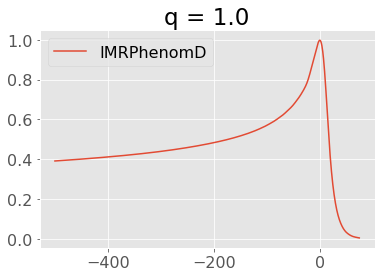

In [26]:
plt.figure()
plt.plot(modelling_params['times'], modelling_params['y'][0], label=modelling_params['approximants'][0])
plt.title(f"q = {modelling_params['x'][0]}")
plt.legend()

In [306]:
def make_deep_autoencoder(input_shape, with_subtraction=True):
    
    # standard autoencoder start
    timeseries_input = tf.keras.Input(shape=(input_shape,))

    x = tf.keras.layers.Dense(128, activation='relu')(timeseries_input)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    x = tf.keras.layers.Dense(1, activation='linear', name='latent_space')(x)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    timeseries_output = tf.keras.layers.Dense(input_shape, activation='linear', name='output1')(x)
    # standard autoencoder end

    if with_subtraction:
        # subtract autoencoder output from the input: i.e., y-yhat
        # use this as the input to another autoencoder
        subtracted_input = tf.keras.layers.subtract([timeseries_input, timeseries_output])
        x = tf.keras.layers.Dense(128, activation='relu', name='input2')(subtracted_input)
        x = tf.keras.layers.Dense(128, activation='relu', name='latent_space_2')(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        subtracted_output = tf.keras.layers.Dense(input_shape, activation='linear')(x)

        final_output = tf.keras.layers.add([timeseries_output, subtracted_output], name='final_output')
        model = tf.keras.Model(inputs=timeseries_input, outputs=[timeseries_output, final_output])

    else:
        x = tf.keras.layers.Dense(128, activation='relu', name='input2')(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
#         x = tf.keras.layers.Dense(128, activation='relu', name='input2')(timeseries_output)
#         x = tf.keras.layers.Dense(2, activation='relu')(x)
#         x = tf.keras.layers.Dense(128, activation='relu')(x)
#         x = tf.keras.layers.Dense(128, activation='relu')(x)
        final_output = tf.keras.layers.Dense(input_shape, activation='linear', name='final_output')(x)

        model = tf.keras.Model(inputs=timeseries_input, outputs=[timeseries_output, final_output])
        
    return model

In [307]:
def initial_fit(model, y, yval=None, sample_weight=None, epochs=10000, batch_size=205, validation_freq=100, lr=None):
        
    loss = {'output1':'mae', 'final_output':'mae'}
    metrics = ['mse']

    if lr == None:
        boundaries = [5000, 5100]
        values = [1e-3, 1e-4, 1e-5]
        # boundaries = [500, 600]
        # values = [1e-3, 1e-4, 1e-5]
        learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
            boundaries, values)
        opt = tf.keras.optimizers.Adam(learning_rate_fn)
    else:
        opt = tf.keras.optimizers.Adam(lr)

    model.compile(optimizer=opt, loss=loss, metrics=metrics)

    callbacks=[]
    tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
    callbacks.append(tqdm_callback)

    if yval is None:
        validation_data=None
    else:
        validation_data=(yval, {'output1': yval, "final_output": yval})
        
    
    history = model.fit(
        x=y,
        y={'output1':y, 'final_output':y},
        epochs=epochs,
        callbacks=callbacks,
        verbose=0,
        batch_size=batch_size,
        validation_data=validation_data,
        validation_freq=validation_freq,
        sample_weight=sample_weight)

    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['output1_mse'], label='output1_mse')
    plt.plot(history.history['final_output_mse'], label='final_output_mse')
    plt.yscale('log')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['val_output1_mse'], label='val_output1_mse')
    plt.plot(history.history['val_final_output_mse'], label='val_final_output_mse')

    plt.yscale('log')
    plt.legend()
    
    return history, model

In [308]:
input_shape = modelling_params['y'].shape[1]

model_sub = make_deep_autoencoder(input_shape=input_shape, with_subtraction=True)
model_nosub = make_deep_autoencoder(input_shape=input_shape, with_subtraction=False)


CPU times: user 2min 57s, sys: 36.8 s, total: 3min 34s
Wall time: 56.9 s


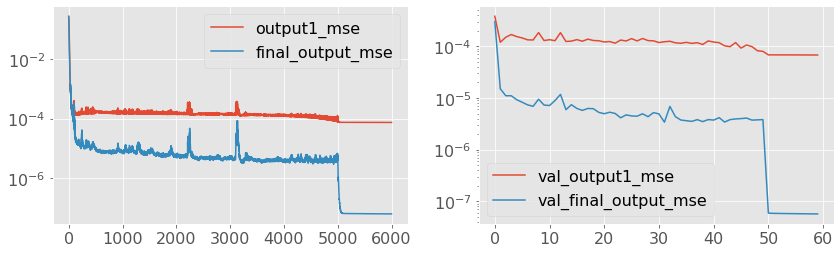

In [339]:
%%time
history_sub, model_sub = initial_fit(
    model_sub,
    y=modelling_params['y'],
    yval=modelling_params['yval'],
    sample_weight=modelling_params['sample_weight'],
    epochs=6000,
    batch_size=205,
    validation_freq=100)


CPU times: user 3min 22s, sys: 1min 22s, total: 4min 45s
Wall time: 1min 9s


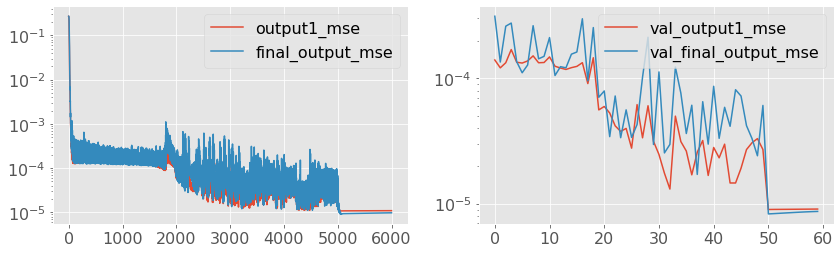

In [309]:
%%time
history_nosub, model_nosub = initial_fit(
    model_nosub,
    y=modelling_params['y'],
    yval=modelling_params['yval'],
    sample_weight=modelling_params['sample_weight'],
    epochs=6000,
    batch_size=205,
    validation_freq=100)

In [310]:
# 2nd stage of fitting - we freeze the autoencoder layers

In [311]:
# lets clone and copy the model so we can compare after

In [312]:
def get_layer_index_from_name(model, layer_name):
    """
    https://stackoverflow.com/questions/50151157/keras-how-to-get-layer-index-when-already-know-layer-name
    """
    index = None
    for idx, layer in enumerate(model.layers):
        if layer.name == layer_name:
            index = idx
            break
    return index

In [340]:
# https://stackoverflow.com/questions/48547688/tensorflow-keras-copy-weights-from-one-model-to-another
# clone_model doesn't copy the weights

model_sub_clone = tf.keras.models.clone_model(model_sub)
model_sub_clone.set_weights(model_sub.get_weights())

model_nosub_clone = tf.keras.models.clone_model(model_nosub)
model_nosub_clone.set_weights(model_nosub.get_weights())

In [314]:
get_layer_index_from_name(model_sub_clone, 'latent_space')

3

In [315]:
get_layer_index_from_name(model_sub_clone, 'input2')

8

In [316]:
get_layer_index_from_name(model_nosub_clone, 'input2')

6

In [317]:
model_nosub_clone.layers[7].name

'dense_224'

In [318]:
# model_nosub_clone.summary()

In [341]:
# freeze the layers you want
idx = get_layer_index_from_name(model_sub_clone, 'input2')
for layer in model_sub_clone.layers[:idx]:
    layer.trainable = False
    
print(model_sub_clone.layers[idx-1].name)
print(model_sub_clone.layers[idx-1].trainable)

print(model_sub_clone.layers[idx].name)
print(model_sub_clone.layers[idx].trainable)


subtract_17
False
input2
True


In [342]:
# freeze the layers you want
idx = get_layer_index_from_name(model_nosub_clone, 'input2')
for layer in model_nosub_clone.layers[:idx]:
    layer.trainable = False
    
    
print(model_nosub_clone.layers[idx-1].name)
print(model_nosub_clone.layers[idx-1].trainable)

print(model_nosub_clone.layers[idx].name)
print(model_nosub_clone.layers[idx].trainable)


dense_223
False
input2
True


In [343]:
%%time
history_sub_clone, model_sub_clone = initial_fit(
    model_sub_clone,
    y=modelling_params['y'],
    yval=modelling_params['yval'],
    sample_weight=modelling_params['sample_weight'],
    epochs=1000,
    batch_size=10,
    validation_freq=100,
    lr=1e-5
)


CPU times: user 1min 17s, sys: 16.7 s, total: 1min 34s
Wall time: 34.6 s



CPU times: user 2min 7s, sys: 36.4 s, total: 2min 44s
Wall time: 49.2 s


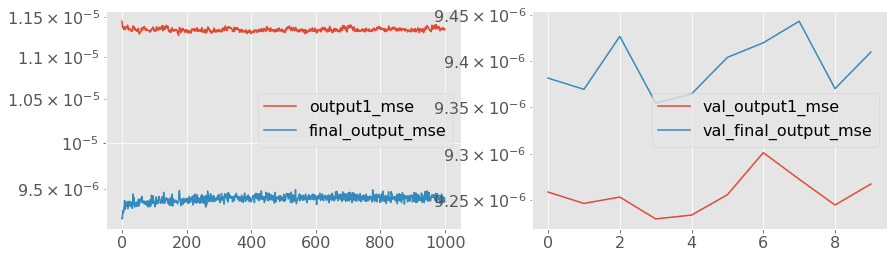

In [334]:
%%time
history_nosub_clone, model_nosub_clone = initial_fit(
    model_nosub_clone,
    y=modelling_params['y'],
    yval=modelling_params['yval'],
    sample_weight=modelling_params['sample_weight'],
    epochs=1000,
    batch_size=10,
    validation_freq=100,
    lr=1e-5
)

In [344]:
def compare_models(index):
    
    times = modelling_params['times']
    y = modelling_params['y']
    
    yhat_sub = model_sub.predict(y)[1][index]
    yhat_sub_clone = model_sub_clone.predict(y)[1][index]
    
    
    yhat_nosub = model_nosub.predict(y)[1][index]
    yhat_nosub_clone = model_nosub_clone.predict(y)[1][index]
    
    y = y[index]
    
    plt.figure(figsize=(18, 10))
    plt.subplot(2, 1, 1)
    plt.plot(times, y, label='true')
    plt.plot(times, yhat_sub, label='yhat_sub')
    plt.plot(times, yhat_sub_clone, label='yhat_sub_clone')
    plt.plot(times, yhat_nosub, label='yhat_nosub')
    plt.plot(times, yhat_nosub_clone, label='yhat_nosub_clone')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.xlim(-200, 0)
#     plt.ylim(0.4, 0.9)
    
    plt.subplot(2, 1, 2)
    plt.plot(times, y-yhat_sub, label='y-yhat_sub')
    plt.plot(times, y-yhat_sub_clone, label='y-yhat_sub_clone')
    plt.plot(times, y-yhat_nosub, label='y-yhat_nosub')
    plt.plot(times, y-yhat_nosub_clone, label='y-yhat_nosub_clone', ls='--')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    title = f"{modelling_params['approximants'][index]}: q={np.around(modelling_params['x'][index], 3)}"
    plt.suptitle(title)

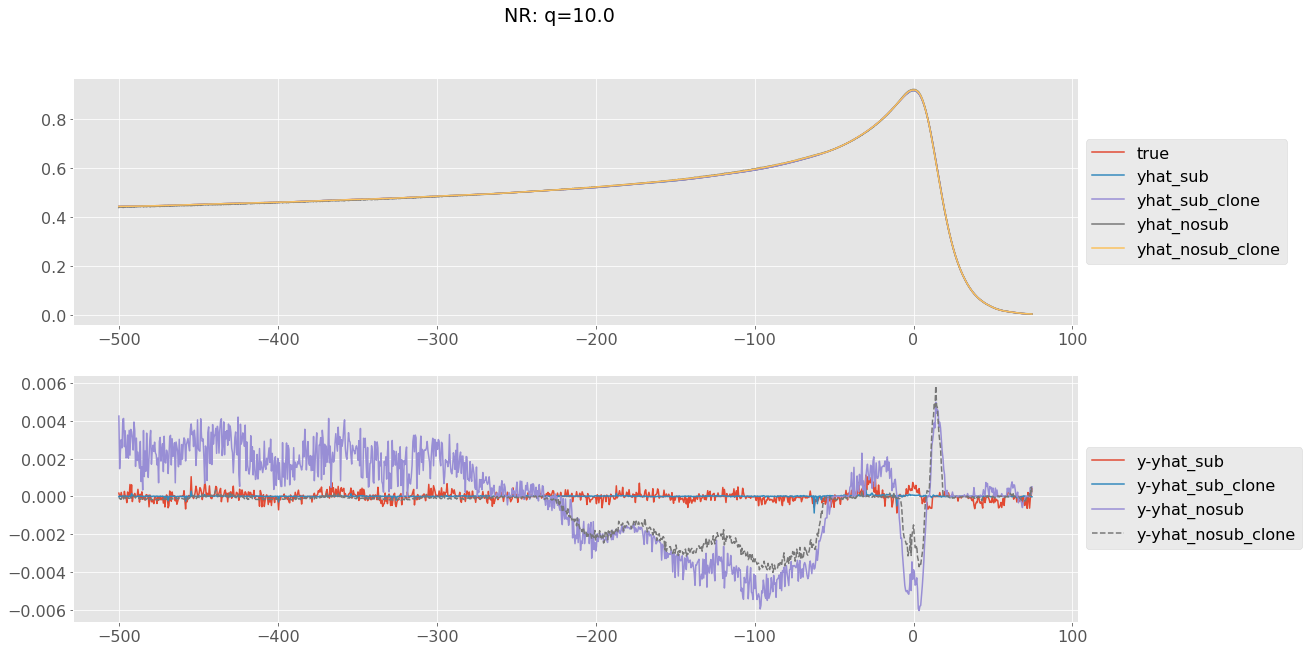

In [345]:
compare_models(-1)

# 

In [99]:
model_encoder = tf.keras.Model(inputs=model_sub_clone.input, outputs=model_sub_clone.get_layer(name='latent_space').output) 

In [73]:
# copy_model_sub_clone = tf.keras.models.clone_model(model_sub)
# copy_model_sub_clone.set_weights(model_sub.get_weights())

In [76]:
copy_model_sub_clone.layers.pop(0)

In [77]:
copy_model_sub_clone.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1150)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          147328      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 16)           2064        dense[0][0]                      
__________________________________________________________________________________________________
latent_space (Dense)            (None, 1)            17          dense_1[0][0]                    
______________________________________________________________________________________________

In [72]:
model_sub_clone.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1150)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          147328      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 16)           2064        dense[0][0]                      
__________________________________________________________________________________________________
latent_space (Dense)            (None, 1)            17          dense_1[0][0]                    
______________________________________________________________________________________________

In [55]:
# doesn't work :(
model_decoder = tf.keras.Model(inputs=model_sub_clone.get_layer(name='latent_space').input, outputs=model_sub_clone.get_layer(name='final_output').output) 

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: dense_1/Relu:0


ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 1150), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'") at layer "dense". The following previous layers were accessed without issue: []

In [100]:
latent_space = model_encoder.predict(modelling_params['y'])
latent_space_val = model_encoder.predict(modelling_params['yval'])

In [101]:
modelling_params.keys()

dict_keys(['x', 'y', 'times', 'approximants', 'sample_weight', 'xval', 'yval', 'approximants_val'])

In [102]:
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
for name in np.unique(modelling_params['approximants']):
    mask = modelling_params['approximants'] == name
    plt.plot(modelling_params['x'][mask], latent_space[:,0][mask], '-', label=name)
plt.legend()

plt.subplot(1, 2, 2)
for name in np.unique(modelling_params['approximants_val']):
    mask = modelling_params['approximants_val'] == name
    plt.plot(modelling_params['xval'][mask], latent_space_val[:,0][mask], '-', label=name)
plt.legend()



In [ ]:
# compute_latent_space(model=model_latent_space, y=y)
# compute_latent_space(model=model_latent_space, y=yval)

# save model

In [238]:
# model_sub_clone.save("deep_autoencoder_amplitude_model.h5")
# model_sub_clone.save("deep_autoencoder_phase_model.h5")

In [ ]:
def make_tag(prefix):
    """
    use temp file and datetime to get a unique name that begins
    with 'prefix', has a middle that is the data and ends
    with a random string.

    by default prefix is 'exp' that is short for experiment.

    name template: '[prefix]_[%y%m%d]_[random]'
    """
    date_now = datetime.datetime.now().strftime("%y%m%d")
    with tempfile.NamedTemporaryFile(prefix=f"{prefix}_{date_now}_") as temp:
        tag = temp.name.split("/")[-1]
    return tag

In [ ]:
save = False

In [ ]:
prefix = f"{data_name}_model"

In [ ]:
if save:
    tag = make_tag(data_to_model)

    print(f"making output directory: {tag}")
    os.makedirs(f"{tag}")

    model_sub_clone.save(os.path.join(tag, "model.h5"))
    
    model_encoder.save(os.path.join(tag, "encoder_model.h5"))
    model_decoder.save(os.path.join(tag, "decoder_model.h5"))